# Fisherova-Kolmogorovova rovnice s radiálně symetrickou počáteční podmínkou


Fisherova-Kolmogorovova rovnice ve 2D pro neznámou funkci $u(x,y,t)$

$$u_t = \Delta{u} + u(1-u)$$ 

Pokud uvažujeme vzhledem k počátku radiálně symetrickou počáteční podmínku lze pomocí transformace do polárních souřadnic $u(x,y) \longrightarrow u(r,\rho), x=r\cos{\rho}, y=r\sin{\rho}$ přepsat rovnici do tvaru

$$u_t = u_{rr} + \frac{1}{r}u_r + u(1-u).$$

Tuto rovnici neumíme převést na ODR s pomocí proměnné $z=r-ct$ stejně jako v případě 1D rovnice, můžeme ale přesto pomocí analýzy jejího chování dojít k zajímavým výsledkům.

Oproti 1D rovnici nám přibyl advekční člen $\frac{1}{r}u_r$, který v závislosti na velikosti $r$ mění rychlost vlny. Pro $r\rightarrow \infty$ je advekční člen zanedbatelný a rovnice má tvar $u_t \approx u_{rr} + u(1-u)$. Pro velká $r$ se proto rychlost vlny blíží $c\approx 2$. Difuzní člen $u_{rr}$ vznikající vlnu radiálně symetricky roztahuje do stran, člen $u(1-u)$ zajistí pro $u<1$ logistický růst až po $u=1$. Pro počáteční $u>1$ bude naopak u klesat k 1.

Z tohoto je tedy vidět, že rychlost vlny $c$ je závislá na poloměru $r$ a není konstatní jako v 1D případě. Jaká je tato závislost si ukážeme na numerických experimentech.

## Numerické experimenty s různými počátečními podmínkami

- popsat jak odhaduji rychlost - počítám ji z velikosti r v nějaké výšce ve všech časech, tuhle 'funkci' potom derivuji. Abych neměl skoky, prokládám body polynom 5 stupně. 

In [2]:
import pde
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use("ggplot")
plt.rcParams.update({'font.size': 12})

# funkce řešení úlohy

def fksolve(domain_size=100.,
           grid_size = 1000,
           max_time = 9,   # 10 steps, as count starting 0
           dt = 0.001,
           tracker_int = 0.05,
           iv_size = 200,
           iv_func = lambda x, y: 1,
           slice_num = 10,
           ylim = 1.1,
           u_level = 0.2):   # u value to approximate the speed at

    fig = plt.figure(figsize=(20,18))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    # grid 
    grid = pde.CartesianGrid([[0, domain_size]]*2, grid_size)
    
    # axisymmetric initial values
    X = np.linspace(-1.,1.,iv_size)
    Y = np.linspace(-1.,1.,iv_size)
    Z = np.zeros((iv_size,iv_size))
    for i in range(0,iv_size): 
        for j in range(0,iv_size):
            if X[i]**2+Y[j]**2<1:
                Z[i,j] = iv_func(X[i],Y[j])
    x0 = np.zeros(grid.shape)
    lo = int((grid_size - iv_size)/2)
    hi = lo+iv_size
    x0[lo:hi, lo:hi] = Z

    state = pde.ScalarField(grid,x0) #.smooth()
    state.plot(cmap='Blues', clim=(0,1), ax=ax1, title='Počáteční podmínka')
    
    # solve the problem
    eq = pde.PDE(
        {"u": "laplace(u) + u*(1-u)"},
    )
    storage = pde.MemoryStorage()
    tracker = ['progress', storage.tracker(interval=tracker_int)] 
    result = eq.solve(state, t_range=max_time, dt=dt, tracker=tracker)
    
    
    # plot results

    
    t_size = len(storage.data)-1
    ts = np.linspace(0, t_size, slice_num, dtype=np.int32)
    
    X = np.linspace(0, domain_size, grid_size)#x_size)
    
    cmap = plt.get_cmap('Blues')
    colors = cmap(np.linspace(.4, 1.0, slice_num))    
    for t, color in zip(ts, colors):
        ax3.plot(X,storage.data[t][int(grid_size/2)], color=color, label='t={:.2f}'.format(t*tracker_int))

    ax3.set_xlabel('y')
    ax3.set_ylabel('u({:.2f},y,t)'.format(domain_size/2))
    ax3.set_title('Řezy řešení u(x,y,t) v x={:.2f}'.format(domain_size/2))
    ax3.set_xlim([0,domain_size])
    ax3.set_ylim([0,ylim])   
    ax3.legend()
    
    result.plot(cmap='Blues', clim=(0,1), ax=ax2, title='Řešení u(x,y,t) v čase t={}'.format(max_time))
    
    # c(r) speed
    ts = np.linspace(0, len(storage.data)-1, slice_num)
    ts = ts.astype(int)
    t_size = len(ts)
    rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])
    
    half_grid_size = int(grid_size/2)

    r_t = np.zeros(t_size)
    
    for t in range(t_size):
        r_data = storage.data[ts[t]][half_grid_size]
        #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
        #r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
        rs_inx = np.argwhere(r_data>=u_level)
        r_t[t] = rs[rs_inx[-1]] + (rs[rs_inx[-1]+1] - rs[rs_inx[-1]]) * ((u_level - r_data[rs_inx[-1]+1])/(r_data[rs_inx[-1]] - r_data[rs_inx[-1]+1])) 
        
    x = np.linspace(0, max_time, len(r_t))
    #z = np.polyfit(x,r_t,5)
    #p = np.poly1d(z)
    #p = p.deriv()
    
    #ax3.plot(x, p(x), color='#0000AA', linewidth=2)
    #ax3.set_xlabel('t')
    #ax3.set_ylabel('c(x,y,t)')
    #ax3.set_title('Aproximace rychlosti pravé části vlny v u(x,y,t)={}'.format(u_level))
    
    ax4.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
    ax4.set_xlabel('t')
    ax4.set_ylabel('c(x,y,t)')
    ax4.set_title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

    plt.show()

    return result, storage, grid

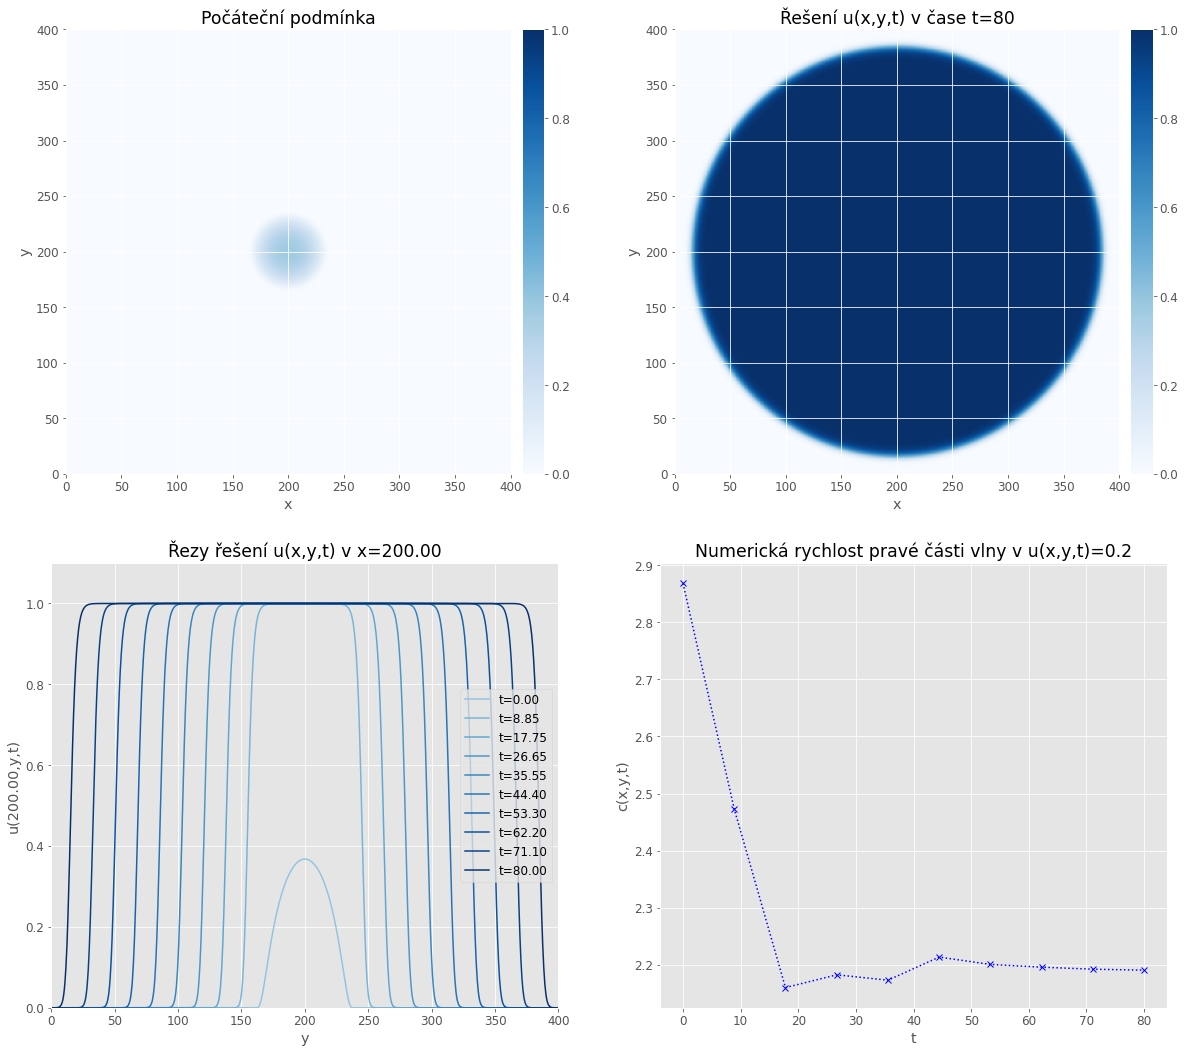

In [113]:
result, storage, grid = fksolve(max_time = 80, 
                                iv_func = lambda x,y: np.exp(-1/(1-x**2-y**2)),
                                dt = .001,
                                domain_size = 400
                                #grid_size = 1000
                               )

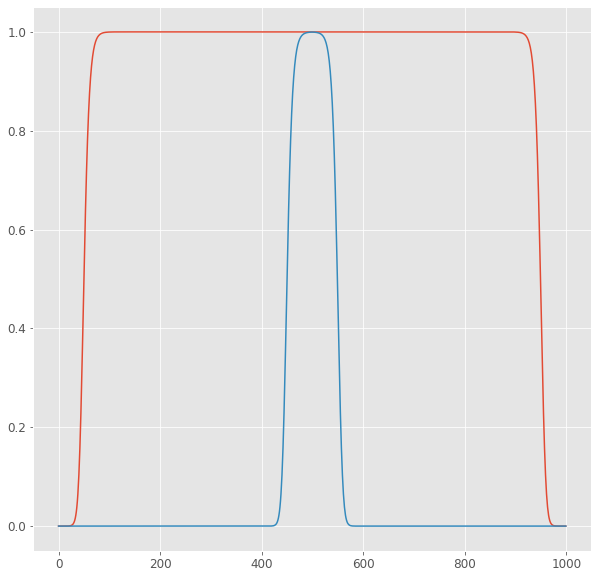

In [124]:
plt.plot(storage.data[-1][400])

ivss = np.concatenate((storage.data[-1][400][0:100], storage.data[-1][400][900:1000]))
iv = np.zeros(1000)
iv[400:600] = ivss
plt.plot(iv)

In [122]:
a = np.array([1,2,3])
b = np.array([4,5,6])
np.concatenate((a,b))

array([1, 2, 3, 4, 5, 6])

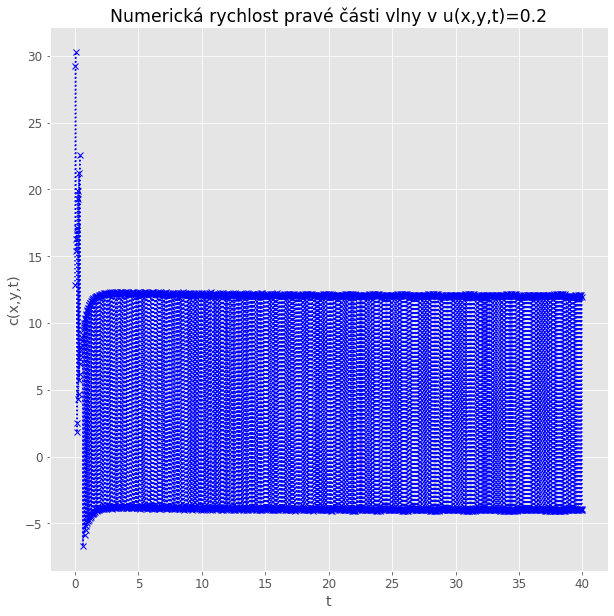

In [115]:



# c(r) speed
slice_num = 1601
grid_size = 1000
u_level = .2
max_time = 40

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    rs_inx = np.argwhere(r_data>=u_level)
    r_t[t] = rs[rs_inx[-1]] + (rs[rs_inx[-1]+1] - rs[rs_inx[-1]]) * ((u_level - r_data[rs_inx[-1]+1])/(r_data[rs_inx[-1]] - r_data[rs_inx[-1]+1])) 
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

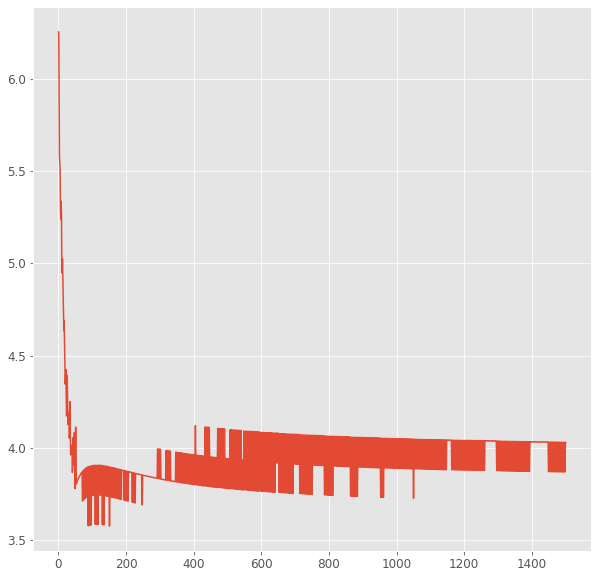

In [116]:
ccc = np.gradient(r_t)/(max_time/t_size)
#print(ccc)

pr = 100

c = np.zeros(len(ccc)-pr)
for i in range(len(ccc)-pr):

    for j in range(pr):
        c[i] += ccc[i+j]#(ccc[i]+ccc[i+1]+ccc[i+2]+ccc[i+3]+ccc[i+4]+ccc[i+5]+ccc[i+6]+ccc[i+7]+ccc[i+8]+ccc[i+9])/10
    
    c[i] = c[i]/pr
    
plt.plot(c)

### Bump funkce

Základní počáteční podmínkou pro nás bude bump funkce $\Phi$, která je radiálně symetrická, je hladká $\Phi \in C^{\infty}$ a je funkcí s kompaktním supportem. Více viz třeba [Wikipedia](https://en.wikipedia.org/wiki/Bump_function).

Z následující simulace je patrný vliv logistického růstu, kdy profil řešení stoupá k 1 i vliv difuze, která vlnu roztahuje do stran. Díky převládajícímu růstu je rychlost vlny $c$ nejprve menší, později se ustálí a blíží se k hodnotě 2.

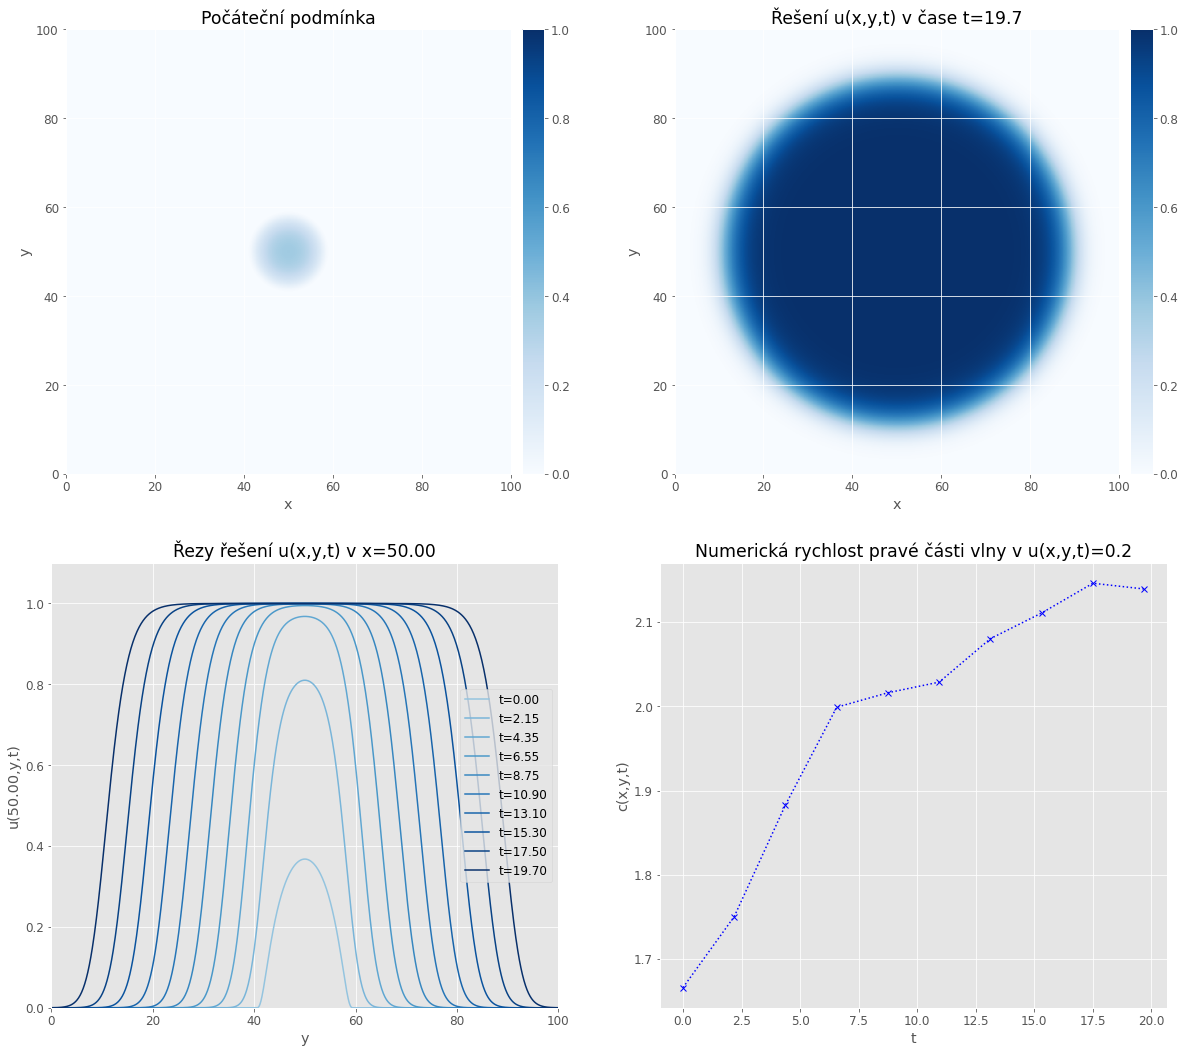

In [3]:
result, storage, grid = fksolve(max_time = 19.7, 
                                iv_func = lambda x,y: np.exp(-1/(1-x**2-y**2)),
                                dt = .001,
                                #grid_size = 1000
                               )

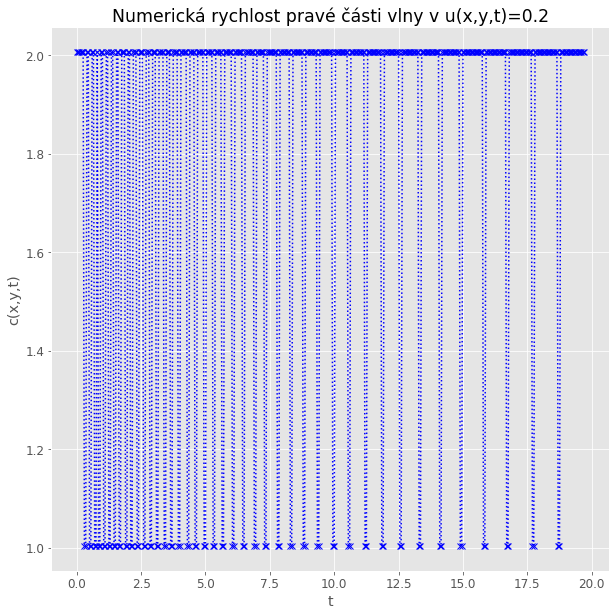

In [35]:
# c(r) speed
slice_num = 395
grid_size = 1000
u_level = .2
max_time = 19.7

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
    r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

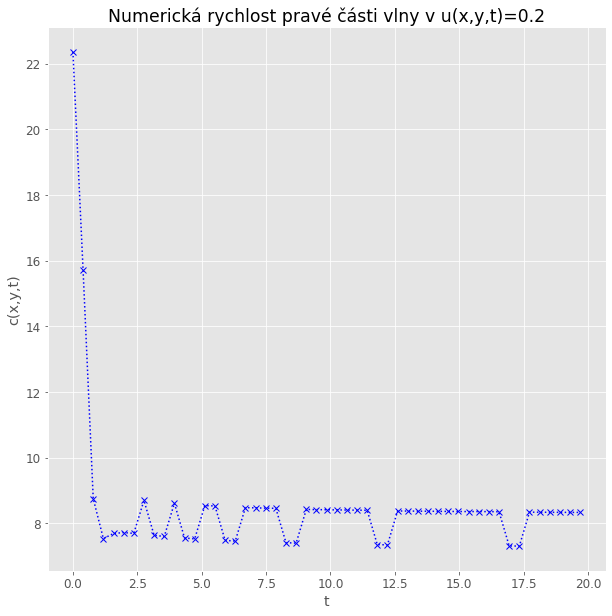

In [129]:



# c(r) speed
slice_num = 51
grid_size = 1000
u_level = .2
max_time = 19.7

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    rs_inx = np.argwhere(r_data>=u_level)
    r_t[t] = rs[rs_inx[-1]] + (rs[rs_inx[-1]+1] - rs[rs_inx[-1]]) * ((u_level - r_data[rs_inx[-1]+1])/(r_data[rs_inx[-1]] - r_data[rs_inx[-1]+1])) 
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

In [125]:
len(storage.data)

1601

### Bump funkce s maximem v $1$

Rozdíl oproti předchozímu případu je ve "velikosti" počáteční podmínky. Díky advekčnímu člunu nejprve hodnota funkce proto poklesne, ale velmi brzy začne díky logistickému růstu opět stoupat. Rychlost vllny se opět z počátečních menších hodnot přibližuje k hodnotě $2$. 

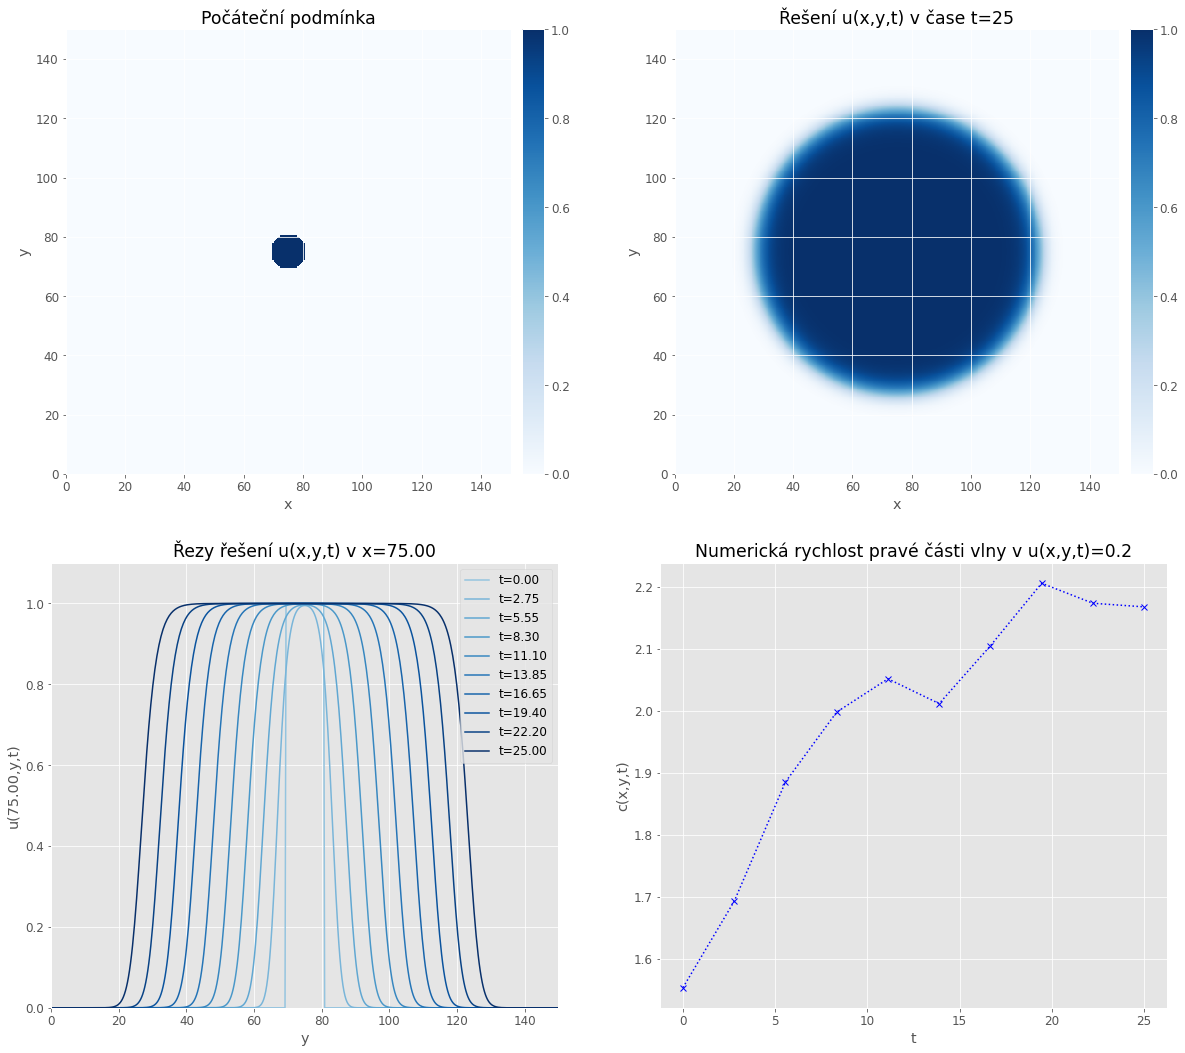

In [45]:
#bump function, size 120, size 1
result, storage, grid = fksolve(iv_size=40,
                         iv_func=lambda x,y: 1, #np.exp(1)*np.exp(-1/(1-x**2-y**2)),
                         domain_size=150,
                         max_time=25,
                         #tracker_int = .1,
                         #dt=.001,
                         grid_size=500
                         )

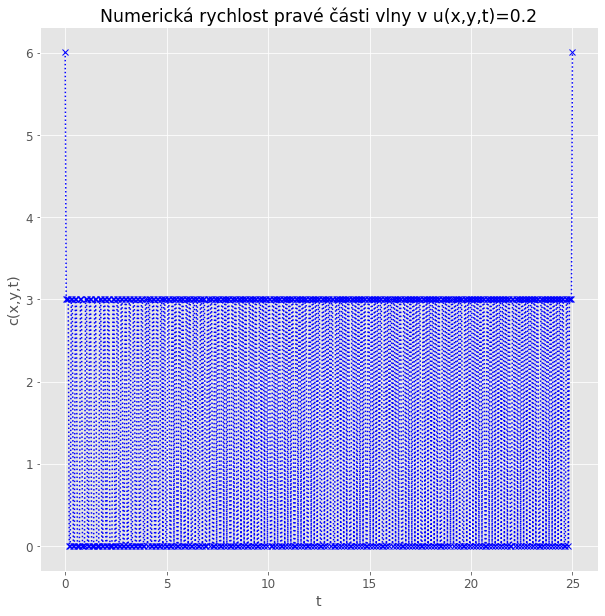

In [50]:
# c(r) speed
slice_num = 500
grid_size = 500
u_level = .2
max_time = 25

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
    r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

In [47]:
len(storage.data[0])

500

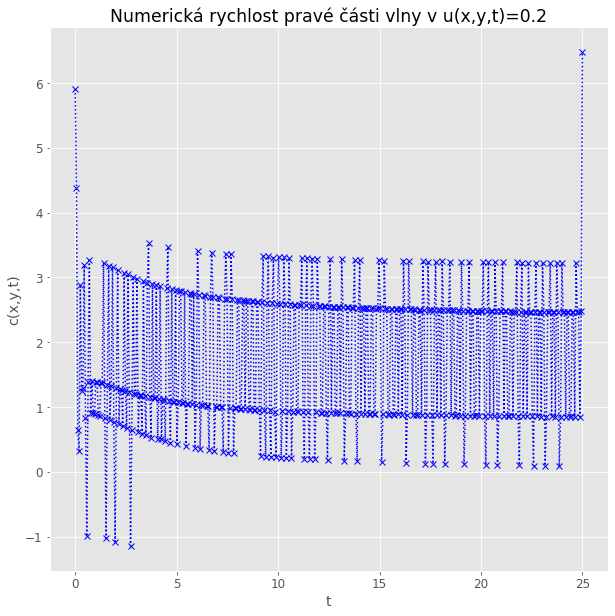

In [44]:



# c(r) speed
slice_num = 395
grid_size = 1000
u_level = .2
max_time = 25

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    rs_inx = np.argwhere(r_data>=u_level)
    r_t[t] = rs[rs_inx[-1]] + (rs[rs_inx[-1]+1] - rs[rs_inx[-1]]) * ((u_level - r_data[rs_inx[-1]+1])/(r_data[rs_inx[-1]] - r_data[rs_inx[-1]+1])) 
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

### Skoková funkce

Co se stane, pokud použijeme nehladkou funkci? Z následujícího experimentu je vidět, že nic zásadního. Stejně jako v případě bump funkce se funkce díky diffuznímu členu okamžitě vyhladí a začne růst až k hodnotě $1$. Rychlost opět stoupá a blíží se hodnotě $c=2.$

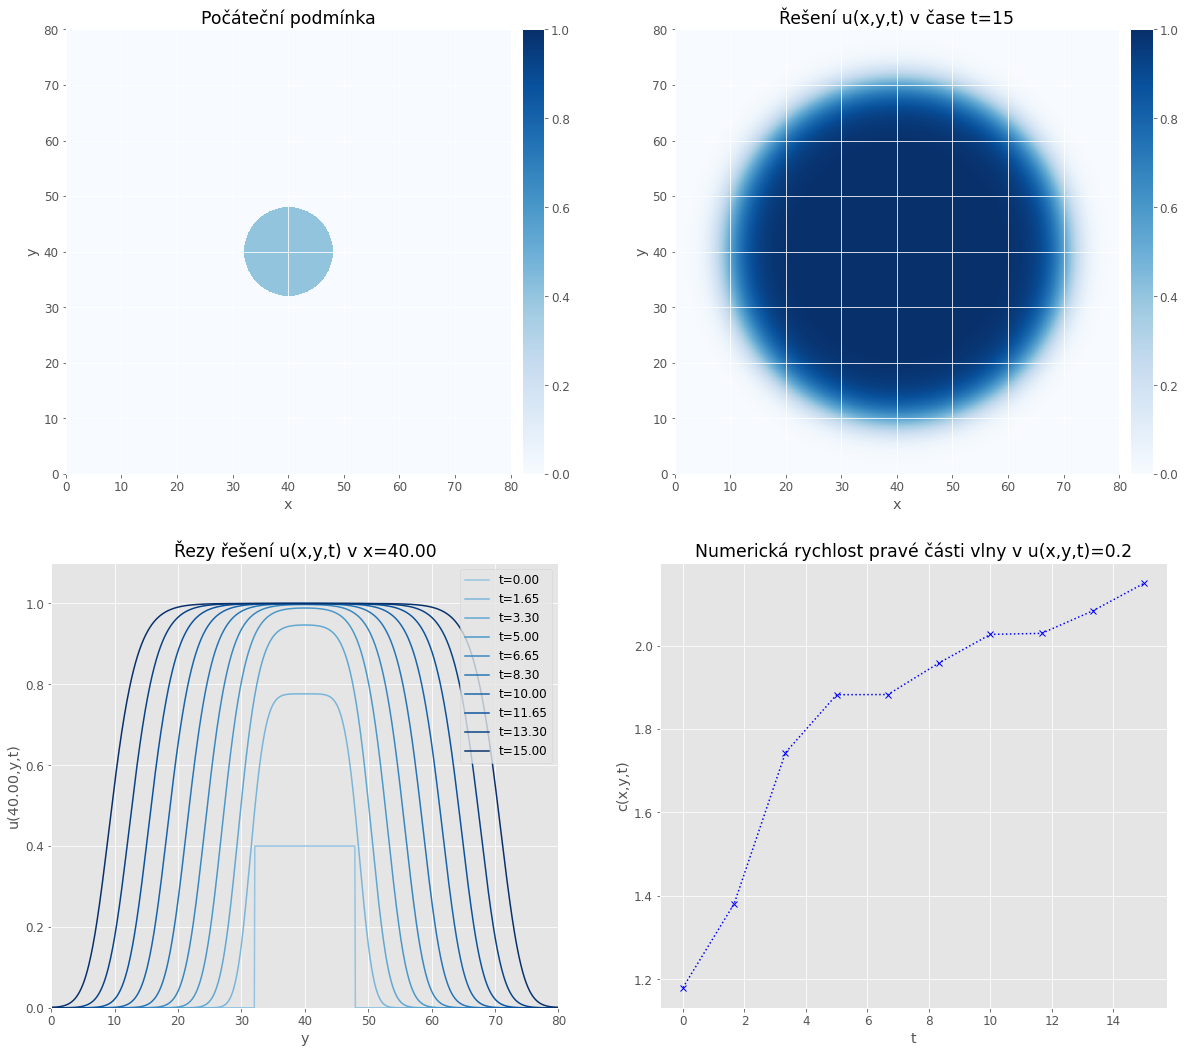

In [56]:
result, storage, grid = fksolve(iv_func = lambda x,y: .4,
                 max_time = 15,
                 domain_size = 80,
                 #grid_size = 500
               )

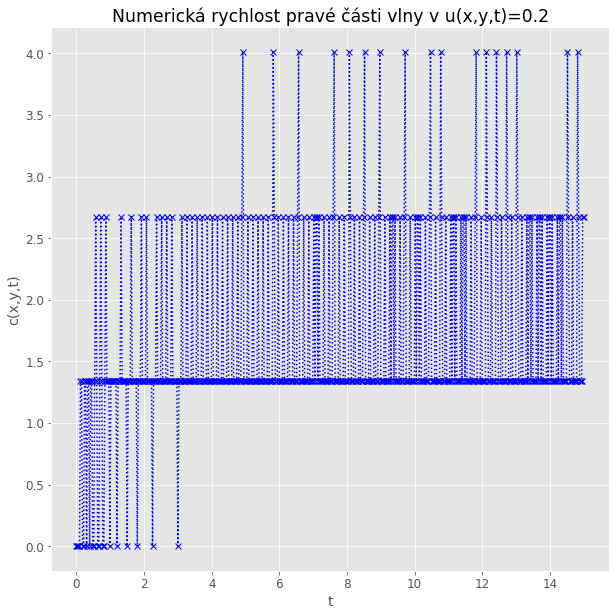

In [58]:
# c(r) speed
slice_num = 501
grid_size = 1000
u_level = .2
max_time = 15

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
    r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

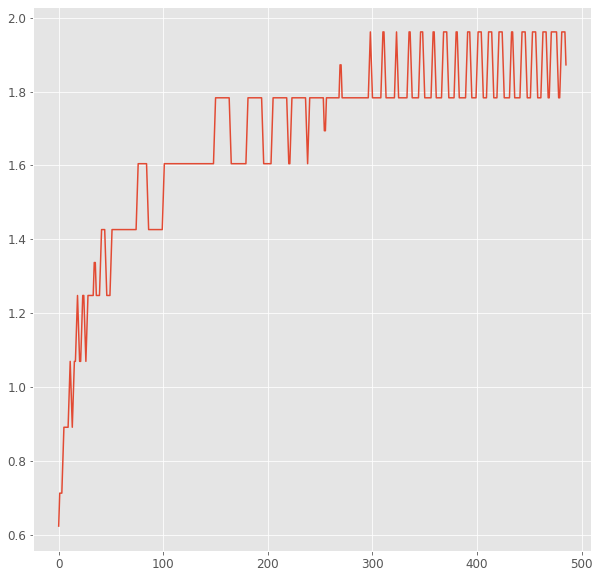

In [79]:
ccc = np.gradient(r_t)/(max_time/t_size)
#print(ccc)

pr = 15

c = np.zeros(len(ccc)-pr)
for i in range(len(ccc)-pr):

    for j in range(pr):
        c[i] += ccc[i+j]#(ccc[i]+ccc[i+1]+ccc[i+2]+ccc[i+3]+ccc[i+4]+ccc[i+5]+ccc[i+6]+ccc[i+7]+ccc[i+8]+ccc[i+9])/10
    
    c[i] = c[i]/pr
    
plt.plot(c)

### Skoková funkce s velmi malým poloměrem

Pokud je počáteční $r$ velmi malé, advekční člen nejprve sníží hodnotu funkce, převládne difuzní člen. Teprve s dostatečně velkým $r$ začne $u$ znovu růst. Rychlost šíření vlny $c$ je nejprve velmi vysoká, kvůli převládajícímu difuznímu členu, sníží se ve chvíli, kdy převládá evoluční člen a nakonec se opět pomalu ustálí na hodnotě $c\approx 2$.

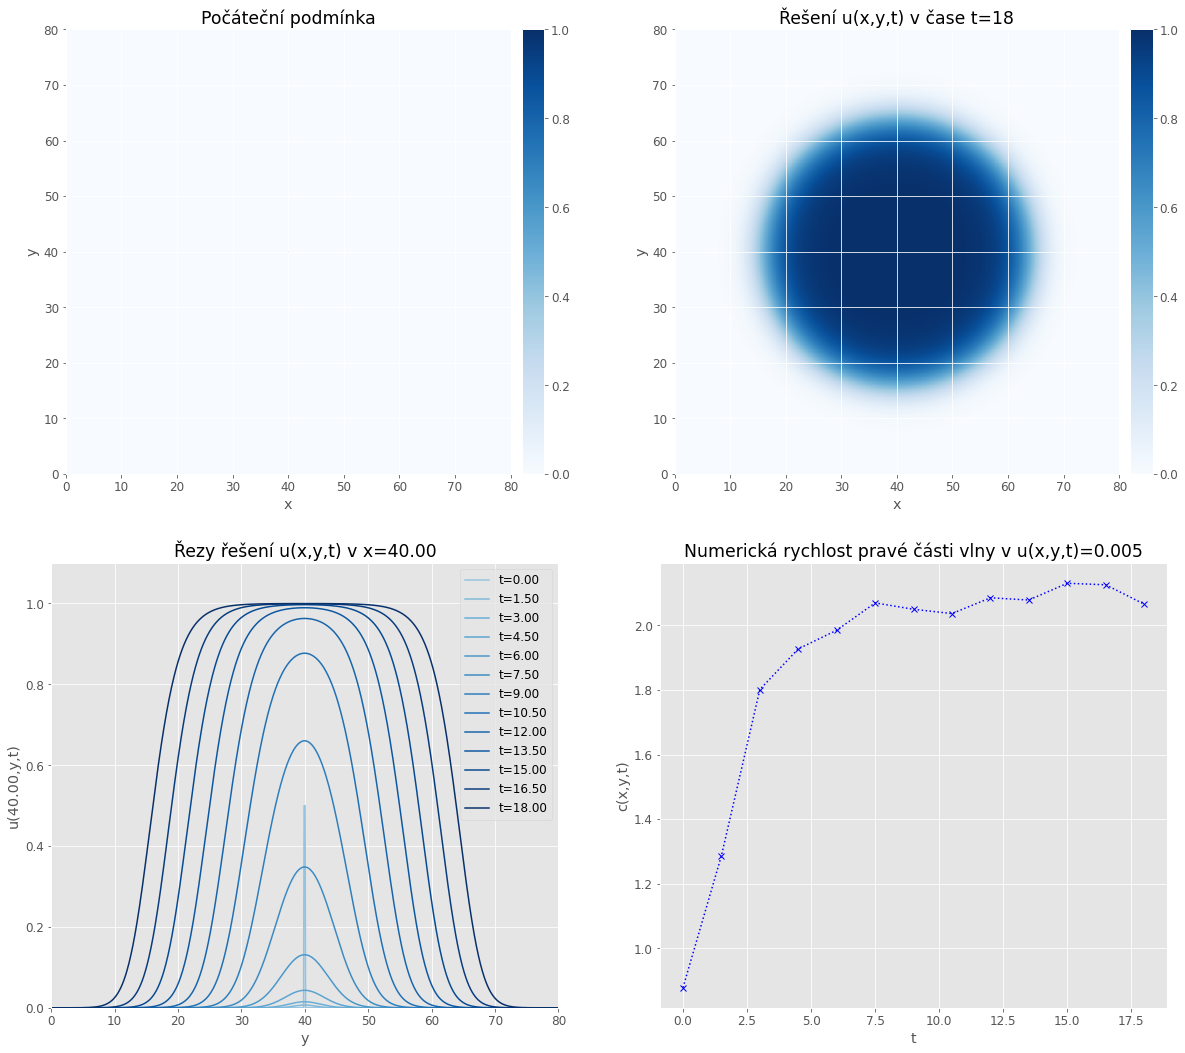

In [81]:
result, storage, grid = fksolve(iv_func= lambda x,y: .5, 
                                iv_size=5, 
                                max_time=18, 
                                u_level=0.005,
                               slice_num = 13,
                               domain_size = 80,
                               #grid_size = 1500
                               )

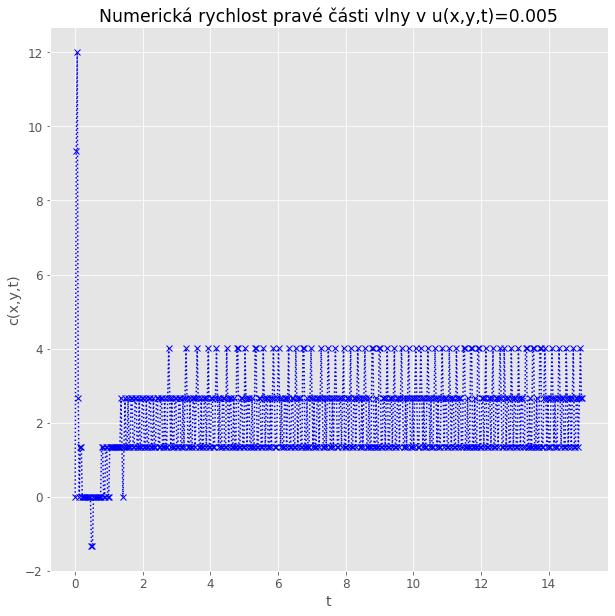

In [86]:
# c(r) speed
slice_num = 500
grid_size = 1000
u_level = .005
max_time = 15

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
    r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

### Skoková funkce s maximem větším než 1

Pokud bude počáteční podmínka mít větší hodnotu než 1, evoluční člen $u(1-u)$ funkci "stáhne" k hodnotě $1$. Stejně jako v předchozím případě se počáteční velmi vysoká rychlost vlny (kvůli vyhlazení difuzí) nejprve sníží a později se přibližuje k hodnotě $c\approx2$.

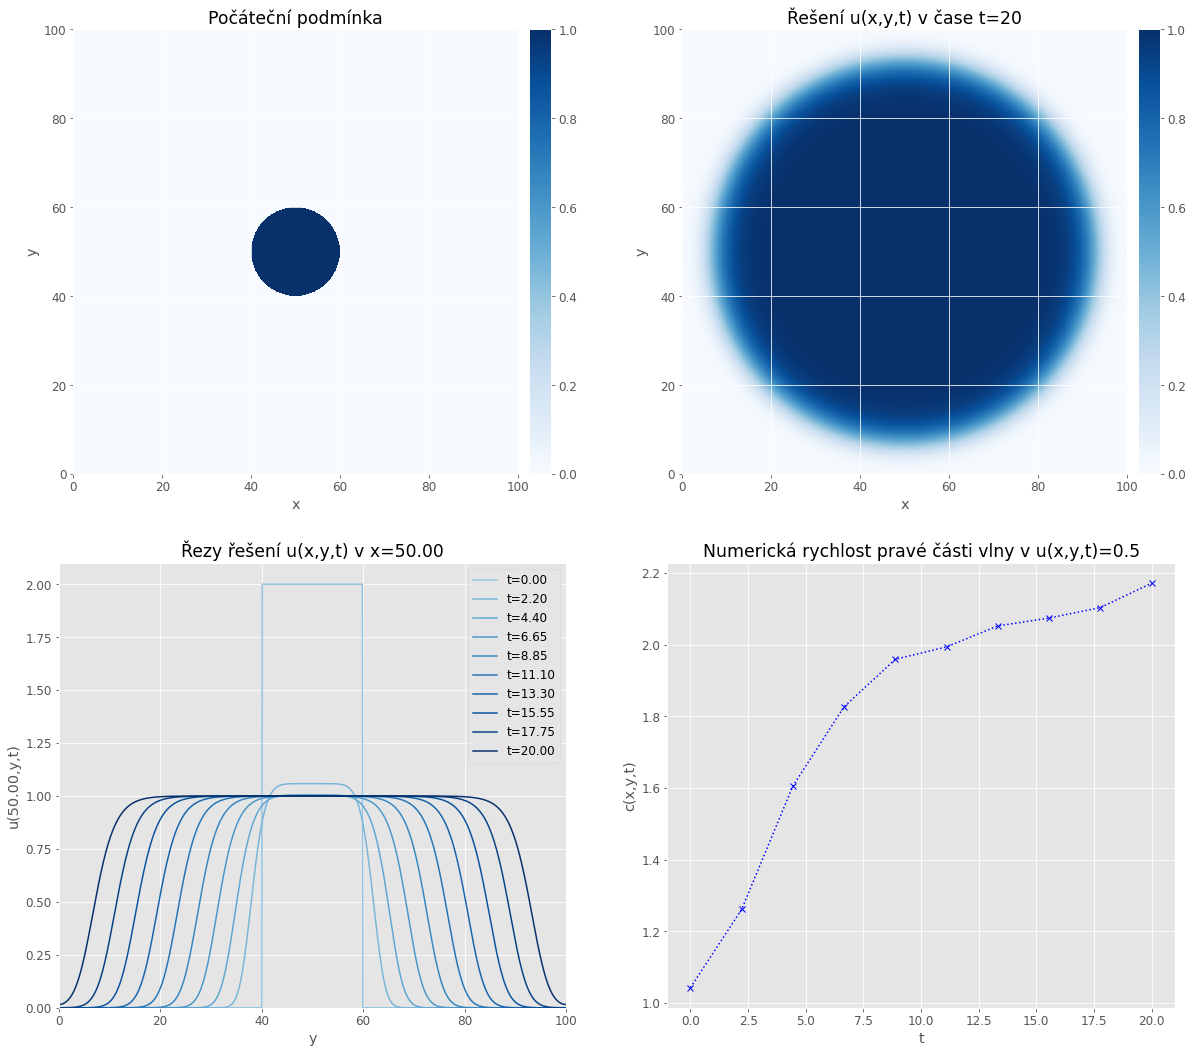

In [95]:
result, storage, grid = fksolve(iv_func= lambda x,y: 2,
                               ylim=2.1,
                               u_level = .5,
                               max_time = 20,
                               #grid_size = 1000
                               )

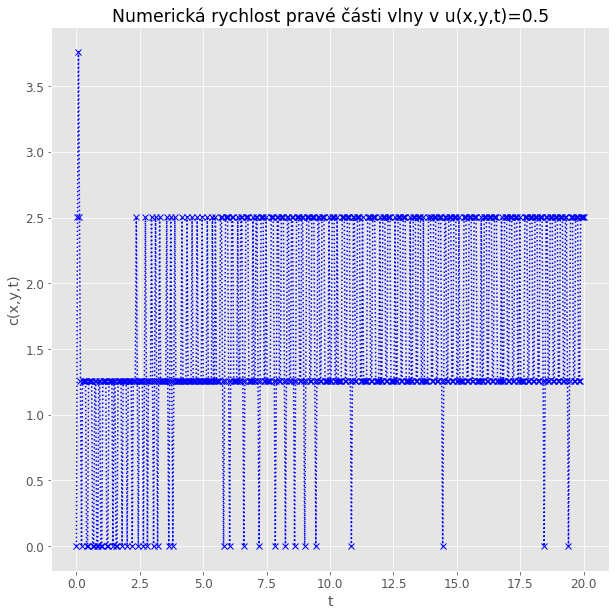

In [99]:
# c(r) speed
slice_num = 501
grid_size = 1000
u_level = .5
max_time = 20

ts = np.linspace(0, len(storage.data)-1, slice_num)
ts = ts.astype(int)
t_size = len(ts)
rs = np.linspace(*grid.axes_bounds[0], grid.shape[0])

half_grid_size = int(grid_size/2)

r_t = np.zeros(t_size)

for t in range(t_size):
    r_data = storage.data[ts[t]][half_grid_size]
    #r_t[t] = np.argwhere(r_data>u_level)[-1][0] * (domain_size/grid_size)
    r_t[t] = rs[np.argwhere(r_data>=u_level)[-1]]
x = np.linspace(0, max_time, len(r_t))


plt.plot(x, np.gradient(r_t)/(max_time/t_size), 'bx:')
plt.xlabel('t')
plt.ylabel('c(x,y,t)')
plt.title('Numerická rychlost pravé části vlny v u(x,y,t)={}'.format(u_level))

plt.show()

### Bump funkce s lokální perturbací

Ukažme si, co se stane, pokud na počáteční bump funkci aplikujeme nějakou lokální perturbaci. 

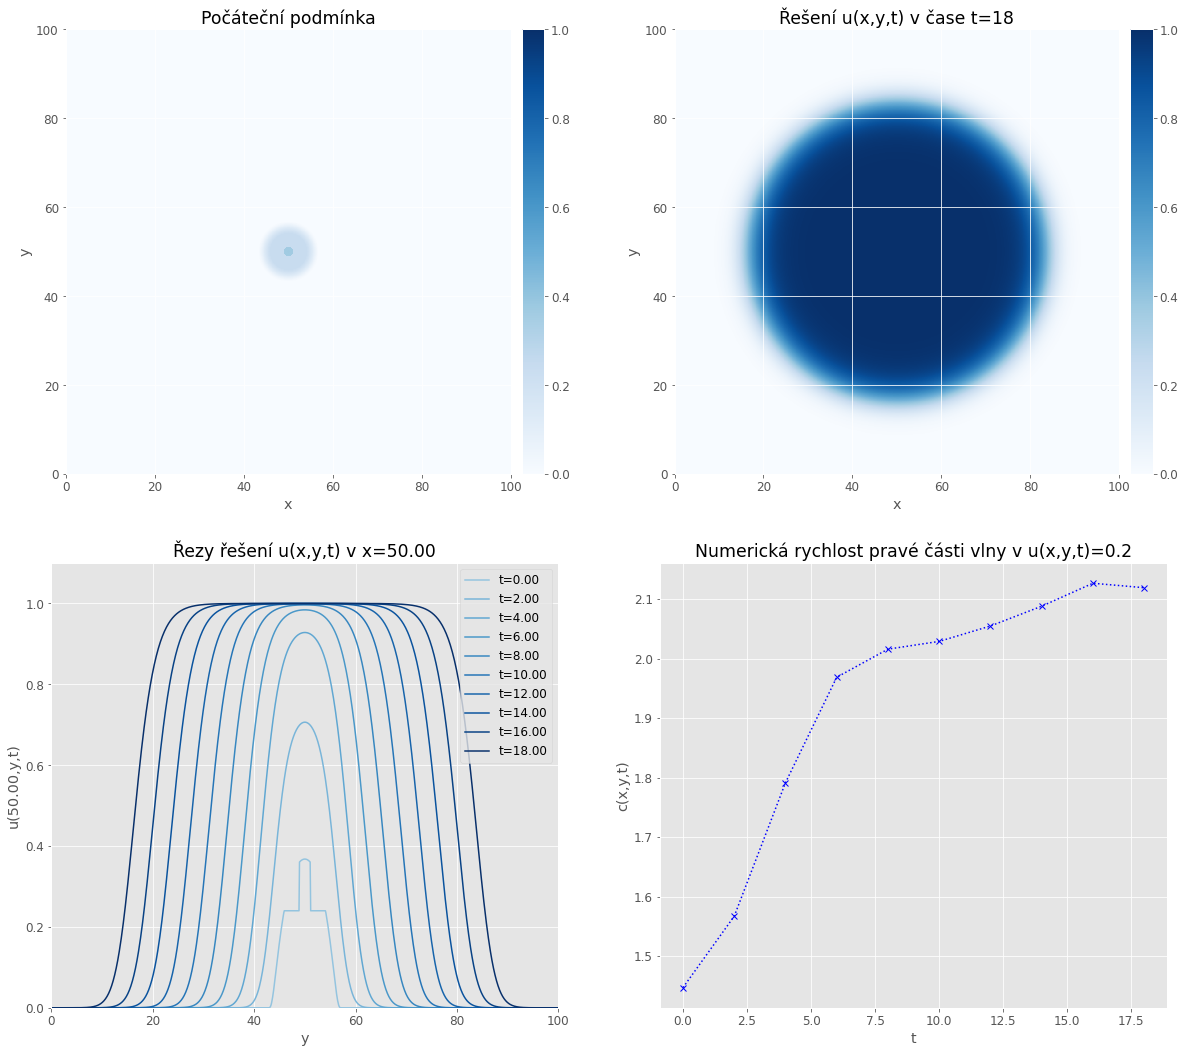

In [100]:
#bump function s perturbací
def ivs(x,y):
    c = x**2+y**2
    #print(c)
    if .02 < c < .3:
        return .24
    else:
        return np.exp(-1/(1-x**2-y**2))


result, storage, grid = fksolve(max_time=18, 
                                iv_func=ivs, 
                                iv_size=150)


### Bump funkce s radiálně nesymetrickou perturbací

Jen pro zajímavost si ukažme případ, kdy počáteční podmínka nebude radiálně sysmetrická.

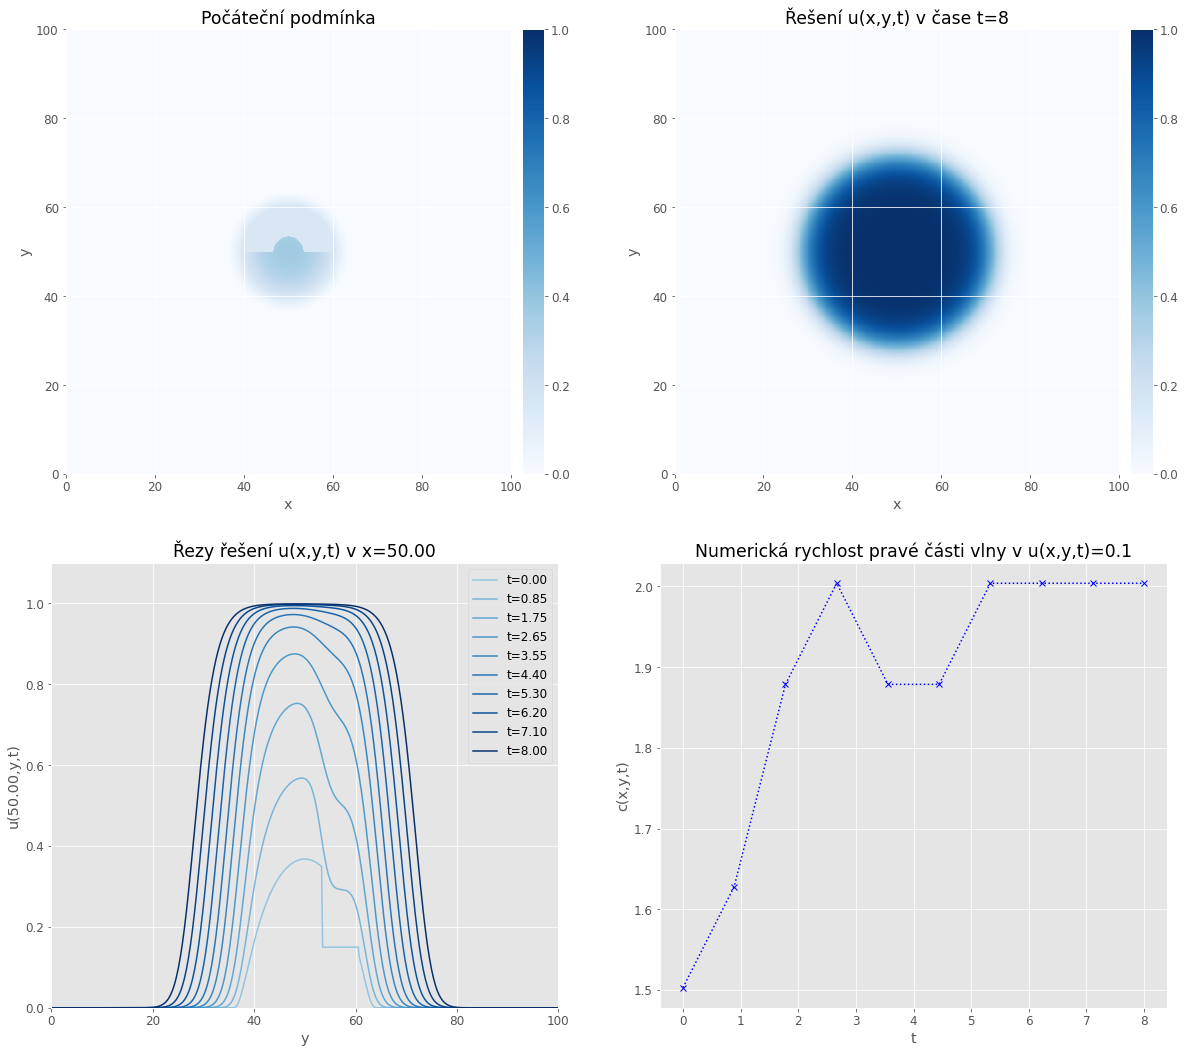

In [6]:
# zkusit totéž co v předchozím případě, ale jen na výseči, podmínka nebude radiálně symetrická
# do podmínky přidat ještě podmínku že x a y jsou kladné

#bump function s NESYMETRICKOU perturbací
def ivs(x,y):
    c = x**2+y**2
    #print(c)
    if (.05 < c < .5) and (y > 0):
        return .15
    else:
        return np.exp(-1/(1-x**2-y**2))


result, storage, grid = fksolve(max_time=8, 
                                iv_func=ivs, 
                                iv_size=150,
                                u_level = .1)

#plt.imshow(np.rot90(storage.data[0]), cmap='Blues', clim=(0,1))
#plt.title('Počáteční podmínka')
#plt.xlabel('x')
#plt.ylabel('y')
#plt.colorbar()
#plt.show()